In [4]:
%reload_ext autoreload
%autoreload 2


In [5]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import matplotlib.pyplot as plt
from scipy import signal as sg

dt = 392e-9
fs = 1 / dt  # waveform sample rate

R1 = 200
C1 = 10e-9
R2 = 180
C2 = 33e-9

tau1 = R1 * C1
tau2 = R2 * C2

zpk_analog = [], [-1 / tau1, -1 / tau2], 1 / tau1 / tau2
zpk_dig = sg.bilinear_zpk(*zpk_analog, fs)
b, a = sg.zpk2tf(*zpk_dig)

# cryo_filter = sg.dlti(b, a, dt=dt)
_trap_filter = b, a, dt

In [20]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

from pytrans import objectives as obj
from pytrans.solver import solver
from models.surface_trap import SurfaceTrap

from pytrans.filter import lfilter_waveform


trap = SurfaceTrap(["DCintop"])

t = np.linspace(0, 1, 256)
voltage = sg.sawtooth(2 * np.pi * 4 * t, width=0.5)

step_objectives = [
    [obj.VoltageObjective(v)]
    for v in voltage
]

global_objectives = [
    obj.SlewRateObjective(),
    obj.SlewRateObjective(50e6, constraint_type='<='),
    # obj.VoltageObjective(10, constraint_type='<='),
    # obj.VoltageObjective(-10, constraint_type='>=')
]

# trap_filter = None
trap_filter = _trap_filter

print("Running solver")
# start_value = np.tile(v_start, (len(step_objectives), 1))
waveform, final_costs = solver(trap, step_objectives, global_objectives, trap_filter=trap_filter, verbose=False)
print("done")

waveform = waveform.value


Running solver
waveform.shape[0] 306
len(step_objective) 306


Compiling step objectives: 100%|██████████| 306/306 [00:02<00:00, 127.06it/s]


done


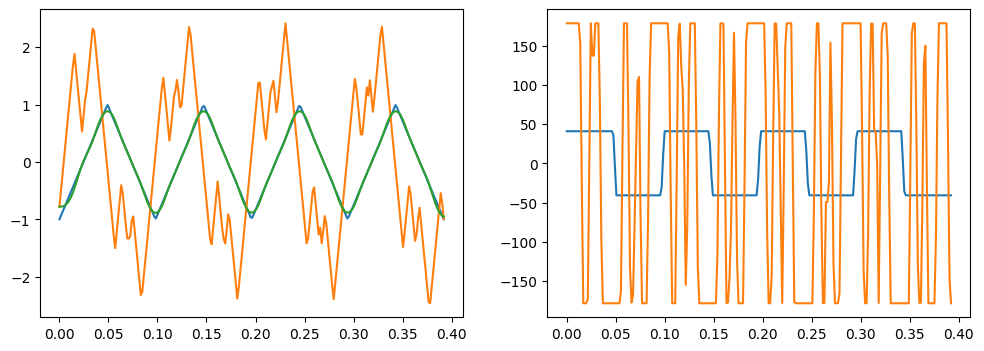

In [21]:

b, a, dt = _trap_filter
tt = t * dt * 1e6
waveform_filt = lfilter_waveform(b, a, waveform)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(tt, voltage)
ax.plot(tt, waveform)
ax.plot(tt, waveform_filt)
# plt.ylim(-2.3, 2.3)

dv = np.gradient(voltage, tt, axis=0)
dw = np.gradient(waveform, tt, axis=0)

ax1.plot(tt, dv)
ax1.plot(tt, dw)


